In [207]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [208]:
# Loading the dataset
dataset = pd.read_csv('pulsar_stars.csv')

1. Once the dataset is loaded, let's see some relevant information about the dataset such as column's titles and types, number of records and shape.

In [209]:
# EDA
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 Mean of the integrated profile                  17898 non-null float64
 Standard deviation of the integrated profile    17898 non-null float64
 Excess kurtosis of the integrated profile       17898 non-null float64
 Skewness of the integrated profile              17898 non-null float64
 Mean of the DM-SNR curve                        17898 non-null float64
 Standard deviation of the DM-SNR curve          17898 non-null float64
 Excess kurtosis of the DM-SNR curve             17898 non-null float64
 Skewness of the DM-SNR curve                    17898 non-null float64
target_class                                     17898 non-null int64
dtypes: float64(8), int64(1)
memory usage: 1.2 MB
None


In [210]:
# Missing values
print (dataset.isnull().sum())

 Mean of the integrated profile                  0
 Standard deviation of the integrated profile    0
 Excess kurtosis of the integrated profile       0
 Skewness of the integrated profile              0
 Mean of the DM-SNR curve                        0
 Standard deviation of the DM-SNR curve          0
 Excess kurtosis of the DM-SNR curve             0
 Skewness of the DM-SNR curve                    0
target_class                                     0
dtype: int64


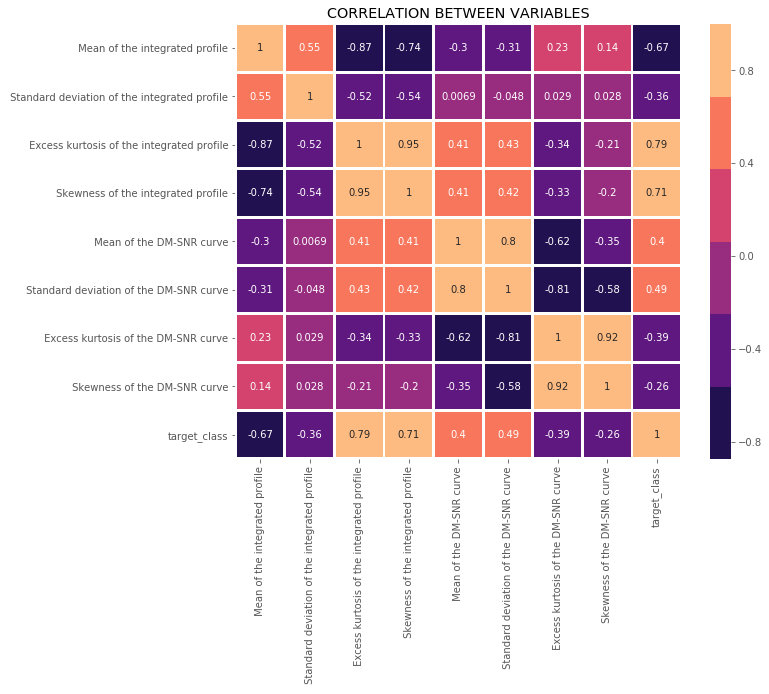

In [211]:
# Plotting the correlation between variables
correlation = dataset.corr()

plt.figure(figsize=(10,8))

sns.heatmap(correlation,annot=True,
            cmap=sns.color_palette("magma"),
            linewidth=2,edgecolor="k")

plt.title("CORRELATION BETWEEN VARIABLES")
plt.savefig('correlation_between_variabels.png', bbox_inches='tight')

Now, Pay close attention to this plot. Note that the proportion between classes in the dataset is very imbalanced, this is a common problem encountered among many datasets in the real-world. This leads to the accuracy paradox, which implies that we'll need to use more than the usual approach to achieve a reasonable performance while training the neural network.

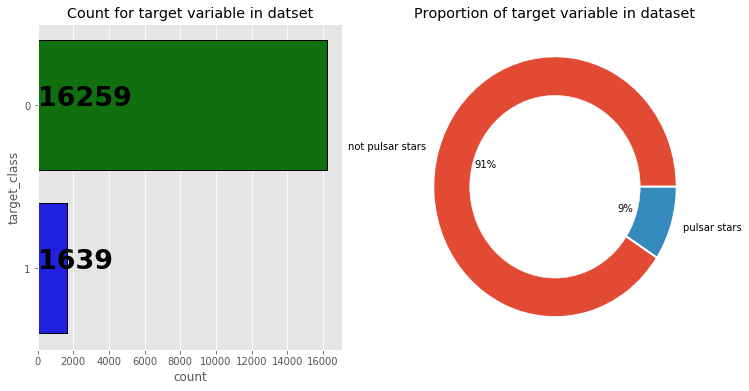

In [212]:
plt.figure(figsize=(12,6))
plt.subplot(121)
ax = sns.countplot(y = dataset["target_class"],
                   palette=["g","b"],
                   linewidth=1,
                   edgecolor="k"*2)
for i,j in enumerate(dataset["target_class"].value_counts().values):
    ax.text(.7,i,j,weight = "bold",fontsize = 27)
plt.title("Count for target variable in datset")


plt.subplot(122)
plt.pie(dataset["target_class"].value_counts().values,
        labels=["not pulsar stars","pulsar stars"],
        autopct="%1.0f%%",wedgeprops={"linewidth":2,"edgecolor":"white"})
my_circ = plt.Circle((0,0),.7,color = "white")
plt.gca().add_artist(my_circ)
plt.subplots_adjust(wspace = .2)
plt.title("Proportion of target variable in dataset")
plt.savefig('proportion_between_classes.jpg')

2. Now, let's divide our dataset into two subsets: data and target.

In [213]:
# Droping the target column
data = dataset.drop(['target_class'], axis=1)

# Normalizing the data for all data points to fit in the range [0,1]
data = data / np.max(data)

target = dataset[['target_class']]

In [214]:
# UNDERSAMPLING Saved for later improvement
#from imblearn.under_sampling import RandomUnderSampler

#rus = RandomUnderSampler(ratio = {0 : 8000, 1 : 1639}, return_indices=True)
#X_rus, y_rus, id_rus = rus.fit_sample(data, target)

In [215]:
# Construct the training and testing splits 
trainX, testX, trainY, testY = train_test_split(data, target, test_size=0.25)

Machine Learning algorithms works better when integer labels are transformed into vector labels. In order to accomplish this transformation I will instantiate a LabelBinarizer object and apply the transformation methods into our trainY and testY sets.

In [216]:
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

With keras, it is possible to define models to our neural network (nn). In this case, we are going to work with a Sequential nn, which is just the nn as we already know, i.e., each layer has as its input the output of the former layer. It is worth mention that our neural network is 8-4-2-1.

In [217]:
# Defining the model
model = Sequential()
model.add(Dense(4, input_shape=(8,), activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

We are going to use the Stochastic Gradient Descent technique as an optimizer, initially with a learning rate = 0.15 and a momentum = 0.9. Furthermore, as this is a binary classification problem, in this case a common loss function to use is the binary cross-entropy. However, as we have imbalanced classes, we need to tell the network that during the training, the positive class is more important than the negative. This has been done through the class weight dictionary, in this case, I am telling the network that during the training data positive points are 7 times more important than the negative ones.

In [218]:
sgd = SGD(0.12, momentum = 0.9)

model.compile(loss='binary_crossentropy', optimizer=sgd,
    metrics=["accuracy"])

#class_weight = {0 : 1., 1 : 7.}

H = model.fit(trainX, trainY, validation_data=(testX, testY), 
              batch_size=128, epochs=200, verbose=2)

Train on 13423 samples, validate on 4475 samples
Epoch 1/200
 - 1s - loss: 0.3229 - acc: 0.9081 - val_loss: 0.3031 - val_acc: 0.9095
Epoch 2/200
 - 0s - loss: 0.3042 - acc: 0.9081 - val_loss: 0.2984 - val_acc: 0.9095
Epoch 3/200
 - 0s - loss: 0.2914 - acc: 0.9081 - val_loss: 0.2726 - val_acc: 0.9095
Epoch 4/200
 - 0s - loss: 0.2334 - acc: 0.9081 - val_loss: 0.1812 - val_acc: 0.9117
Epoch 5/200
 - 0s - loss: 0.1457 - acc: 0.9481 - val_loss: 0.1196 - val_acc: 0.9651
Epoch 6/200
 - 0s - loss: 0.1096 - acc: 0.9683 - val_loss: 0.0973 - val_acc: 0.9727
Epoch 7/200
 - 0s - loss: 0.0951 - acc: 0.9722 - val_loss: 0.0893 - val_acc: 0.9736
Epoch 8/200
 - 0s - loss: 0.0896 - acc: 0.9742 - val_loss: 0.0848 - val_acc: 0.9759
Epoch 9/200
 - 0s - loss: 0.0864 - acc: 0.9752 - val_loss: 0.0827 - val_acc: 0.9768
Epoch 10/200
 - 0s - loss: 0.0857 - acc: 0.9756 - val_loss: 0.0827 - val_acc: 0.9759
Epoch 11/200
 - 0s - loss: 0.0849 - acc: 0.9761 - val_loss: 0.0814 - val_acc: 0.9768
Epoch 12/200
 - 0s - loss

Epoch 97/200
 - 0s - loss: 0.0724 - acc: 0.9792 - val_loss: 0.0700 - val_acc: 0.9799
Epoch 98/200
 - 0s - loss: 0.0723 - acc: 0.9790 - val_loss: 0.0701 - val_acc: 0.9799
Epoch 99/200
 - 0s - loss: 0.0726 - acc: 0.9797 - val_loss: 0.0726 - val_acc: 0.9790
Epoch 100/200
 - 0s - loss: 0.0745 - acc: 0.9790 - val_loss: 0.0699 - val_acc: 0.9801
Epoch 101/200
 - 0s - loss: 0.0725 - acc: 0.9794 - val_loss: 0.0701 - val_acc: 0.9799
Epoch 102/200
 - 0s - loss: 0.0724 - acc: 0.9788 - val_loss: 0.0699 - val_acc: 0.9803
Epoch 103/200
 - 0s - loss: 0.0723 - acc: 0.9791 - val_loss: 0.0699 - val_acc: 0.9801
Epoch 104/200
 - 0s - loss: 0.0726 - acc: 0.9788 - val_loss: 0.0718 - val_acc: 0.9792
Epoch 105/200
 - 0s - loss: 0.0720 - acc: 0.9788 - val_loss: 0.0740 - val_acc: 0.9803
Epoch 106/200
 - 0s - loss: 0.0728 - acc: 0.9787 - val_loss: 0.0702 - val_acc: 0.9792
Epoch 107/200
 - 0s - loss: 0.0720 - acc: 0.9797 - val_loss: 0.0706 - val_acc: 0.9812
Epoch 108/200
 - 0s - loss: 0.0721 - acc: 0.9793 - val_lo

Epoch 193/200
 - 0s - loss: 0.0726 - acc: 0.9787 - val_loss: 0.0686 - val_acc: 0.9812
Epoch 194/200
 - 0s - loss: 0.0716 - acc: 0.9796 - val_loss: 0.0693 - val_acc: 0.9801
Epoch 195/200
 - 0s - loss: 0.0708 - acc: 0.9794 - val_loss: 0.0686 - val_acc: 0.9803
Epoch 196/200
 - 0s - loss: 0.0715 - acc: 0.9794 - val_loss: 0.0690 - val_acc: 0.9810
Epoch 197/200
 - 0s - loss: 0.0712 - acc: 0.9796 - val_loss: 0.0699 - val_acc: 0.9799
Epoch 198/200
 - 0s - loss: 0.0707 - acc: 0.9795 - val_loss: 0.0697 - val_acc: 0.9799
Epoch 199/200
 - 0s - loss: 0.0712 - acc: 0.9798 - val_loss: 0.0690 - val_acc: 0.9817
Epoch 200/200
 - 0s - loss: 0.0711 - acc: 0.9794 - val_loss: 0.0696 - val_acc: 0.9808


At this point we are ready to analyze the results from our neural network. Calling the .predict method on our model will give us the predictions from our testing set. In addition, as the output from our network is given by the sigmoid activation function, the outputs values are real number in the range [0,1], so, we need to apply a step function to threshold the outputs to binary class labels. Lastly, we print a report showing us the performance of the model.

In [219]:
predictions = model.predict(testX, batch_size=128)

# apply a step function to threshold the outputs to binary
# class labels
predictions[predictions < 0.5] = 0
predictions[predictions >= 0.5] = 1

report = classification_report(testY, predictions, 
                               target_names=['Non-pulsar Star', 'Pulsar Star'])

print(report)

                 precision    recall  f1-score   support

Non-pulsar Star       0.99      0.99      0.99      4070
    Pulsar Star       0.92      0.86      0.89       405

      micro avg       0.98      0.98      0.98      4475
      macro avg       0.95      0.93      0.94      4475
   weighted avg       0.98      0.98      0.98      4475



It is also important to visualize the confusion matrix of our predictions, this can lead us to a more precise visualization and comprehension about where the numbers in our report came from.

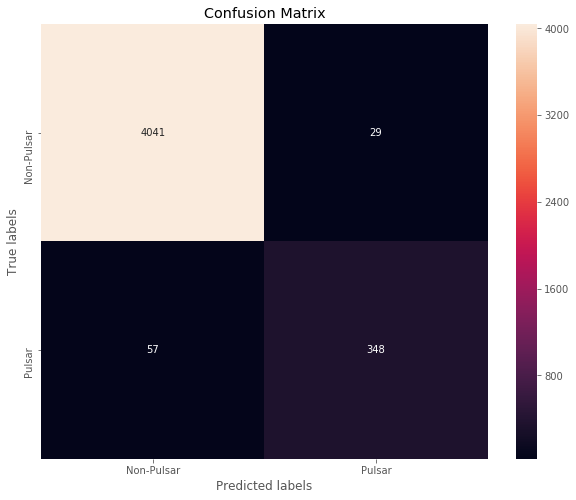

In [220]:
conf_matrix = confusion_matrix(testY, predictions)

# Plot the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt     

plt.figure(figsize=(10,8))
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax = ax, fmt='d') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non-Pulsar', 'Pulsar'])
ax.yaxis.set_ticklabels(['Non-Pulsar', 'Pulsar'])
plt.savefig('confusion_matrix.png')

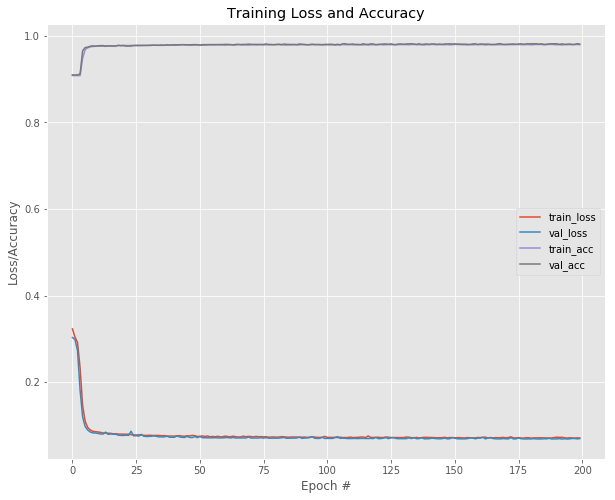

In [221]:
# Plotting the curve Epoch vs. Loss/Accuracy
plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.plot(np.arange(0, 200), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 200), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 200), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 200), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('plot.png')